In [75]:
import json

In [76]:
def get_scores_prompting(task, dataset, n_shot, base_path="../../zero-shot-absa-quad/generations/zeroshot/", data_type="test"):
    power, vram, times = [], [], []
    n_samples = 0

    for seed in range(5):
        file_path = f"{base_path}/{task}_{dataset}_{data_type}_gemma3:27b_{seed}{'_label' if data_type == 'test' else ''}_{n_shot}_PERFORMANCE.json"
        with open(file_path, "r") as f:
            data = json.load(f)
            n_samples += len(data)
            power.extend(ex["avg_gpu_power_eval_W"] for ex in data)
            vram.extend(ex["avg_gpu_vram_eval_MB"] for ex in data)
            times.extend(ex["total_time_eval"] for ex in data)
            
    # create plot to show values of power
    # import matplotlib.pyplot as plt
    # plt.plot(times, label='frequency')

    return {
        "avg_gpu_power_eval_W": sum(power) / len(power),
        "avg_gpu_vram_eval_MB": sum(vram) / len(vram),
        "total_time_eval": sum(times) * 20 / 60,
        "n_samples": n_samples * 20 / 5,
        "kWH": (sum(power) / len(power) * sum(times) * 20 / 3600)
    }

def get_scores_prompting_all(task, n_shot, base_path="../../zero-shot-absa-quad/generations/zeroshot/", data_type="test"):
    datasets = ["rest15", "rest16", "hotels", "coursera", "flightabsa"]
    all_stats = [get_scores_prompting(task, ds, n_shot, base_path, data_type) for ds in datasets]

    return {
        key: sum(stat[key] for stat in all_stats) / len(all_stats)
        for key in all_stats[0]
    }


In [77]:
for dataset in ["rest16"]:
    print(get_scores_prompting("tasd", dataset, 50, base_path="../_out_synthetic_examples/01_llm_annotate_train", data_type="train"))

{'avg_gpu_power_eval_W': 248.13150366428926, 'avg_gpu_vram_eval_MB': 19132.8, 'total_time_eval': 766.0385266939799, 'n_samples': 1640.0, 'kWH': 3167.971524889234}


In [78]:
def draw_plot(title_x, title_y, plot_title, data=[], maximum_y=1000, maximum_x=1000):
    import matplotlib.pyplot as plt
    from matplotlib import font_manager
    import numpy as np

    font_path = 'Manrope-Regular.ttf'
    font_manager.fontManager.addfont(font_path)
    prop = font_manager.FontProperties(fname=font_path)

    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = prop.get_name()
    plt.style.use('seaborn-v0_8-paper') 

    plt.figure(figsize=(6, 4), dpi=100)
    
    for d in data:
        x = np.array(d["x"])
        y = np.array(d["y"])
        plt.plot(x, y, color=d["line_color"], linewidth=2, label=d["legend_title_line"])
        plt.scatter([x[-1]], [y[-1]], color=d["line_color"], s=50, zorder=5)

    plt.xlabel(title_x, fontsize=11)
    plt.ylabel(title_y, fontsize=11)
    plt.title(plot_title, fontsize=12, pad=10)

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.minorticks_on()

    plt.xlim(-20, maximum_x + 20)
    plt.ylim(-20, maximum_y + 40)

    # Add legend below the plot
    plt.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=2,
        fontsize=9,
        frameon=False
    )

    plt.tight_layout()
    plt.savefig("prediction_time_plot.pdf", format="pdf", dpi=300, bbox_inches="tight")
    plt.show()

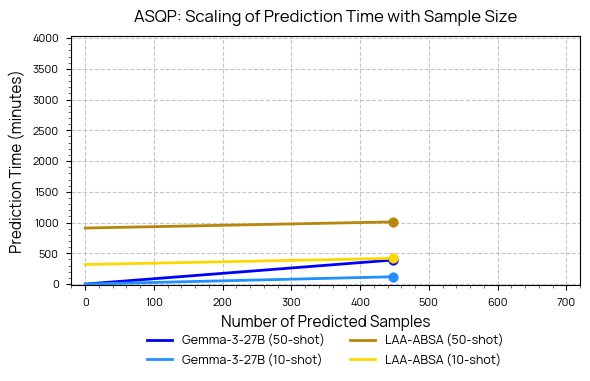

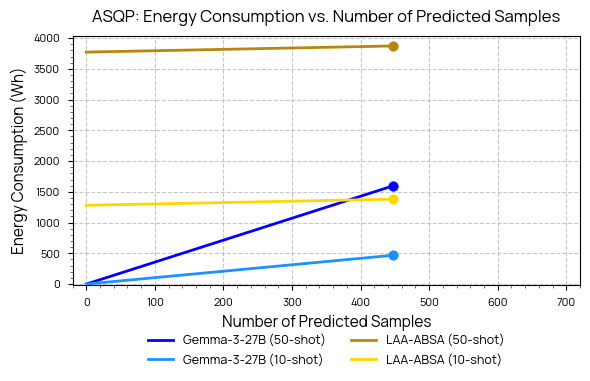

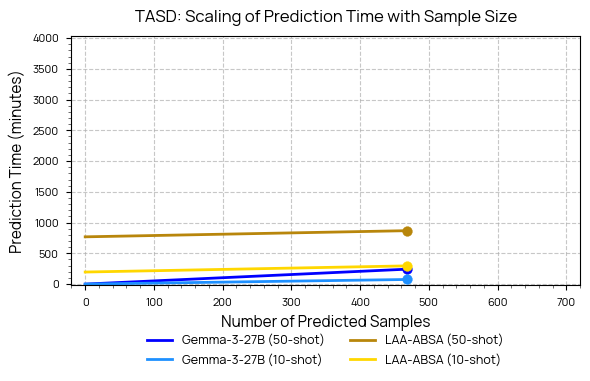

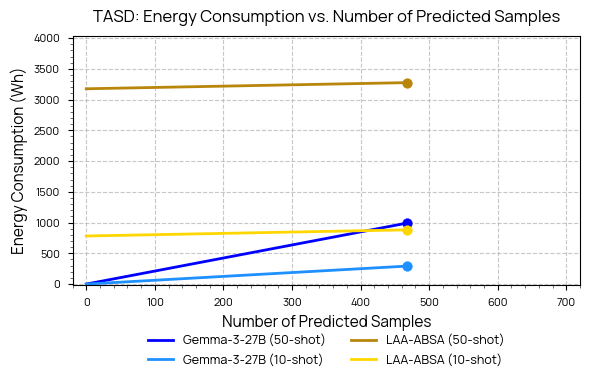

In [79]:
for task in ["asqp", "tasd"]:

    scores_gemma_3_27b_50 =  get_scores_prompting_all(task, 50)
    scores_gemma_3_27b_10 = get_scores_prompting_all(task, 10)
    scores_gemma_3_27b_50_train = get_scores_prompting_all(task, 50, base_path="../_out_synthetic_examples/01_llm_annotate_train", data_type="train")
    scores_gemma_3_27b_10_train = get_scores_prompting_all(task, 10, base_path="../_out_synthetic_examples/01_llm_annotate_train", data_type="train") 
    
    draw_plot("Number of Predicted Samples", "Prediction Time (minutes)", f"{task.upper()}: Scaling of Prediction Time with Sample Size", [
    {
        "x": [0, scores_gemma_3_27b_50["n_samples"]],
        "y": [0, scores_gemma_3_27b_50["total_time_eval"]],
        "legend_title_line": "Gemma-3-27B (50-shot)",
        "line_color": "blue"
    },
    {
        "x": [0, scores_gemma_3_27b_10["n_samples"]],
        "y": [0, scores_gemma_3_27b_10["total_time_eval"]],
        "legend_title_line": "Gemma-3-27B (10-shot)",
        "line_color": "dodgerblue"
    },
    {
        "x": [0, scores_gemma_3_27b_50["n_samples"]],
        "y": [scores_gemma_3_27b_50_train["total_time_eval"], scores_gemma_3_27b_50_train["total_time_eval"] + 100] ,
        "legend_title_line": "LAA-ABSA (50-shot)",
        "line_color": "darkgoldenrod"
    },
    {
        "x": [0, scores_gemma_3_27b_10["n_samples"]],
        "y": [scores_gemma_3_27b_10_train["total_time_eval"], scores_gemma_3_27b_10_train["total_time_eval"] + 100] ,
        "legend_title_line": "LAA-ABSA (10-shot)",
        "line_color": "gold"
    }
    ], maximum_y=4000, maximum_x=700)
    
    
    draw_plot("Number of Predicted Samples", "Energy Consumption (Wh)", f"{task.upper()}: Energy Consumption vs. Number of Predicted Samples", [
        {
                "x": [0, scores_gemma_3_27b_50["n_samples"]],
                "y": [0, scores_gemma_3_27b_50["kWH"]],
                "legend_title_line": "Gemma-3-27B (50-shot)",
                "line_color": "blue"
        },
        {
                "x": [0, scores_gemma_3_27b_10["n_samples"]],
                "y": [0, scores_gemma_3_27b_10["kWH"]],
                "legend_title_line": "Gemma-3-27B (10-shot)",
                "line_color": "dodgerblue"
        },
        {
                "x": [0, scores_gemma_3_27b_50["n_samples"]],
                "y": [scores_gemma_3_27b_50_train["kWH"], scores_gemma_3_27b_50_train["kWH"] + 100],
                "legend_title_line": "LAA-ABSA (50-shot)",
                "line_color": "darkgoldenrod"
        },
        {
                "x": [0, scores_gemma_3_27b_10["n_samples"]],
                "y": [scores_gemma_3_27b_10_train["kWH"], scores_gemma_3_27b_10_train["kWH"] + 100],
                "legend_title_line": "LAA-ABSA (10-shot)",
                "line_color": "gold"
        }
    ], maximum_y=4000, maximum_x=700)
